#  EagleEye_v7 tutorial


We import necessary libraries and set up custom plot configurations for consistency.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory setup for custom modules
import sys
module_path = '../../eagleeye'
sys.path.append(module_path)
import EagleEye_v7

# Custom plotting settings
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'gray'
})


## 1. Generate the datasets 

In [2]:
from utils_37 import generate_uniform_with_Gaussian_ove_under

# Generate data with anomalies
num_points = 50000
anomaly_sizes_o = [50, 100, 200, 300, 500, 700, 900]
anomaly_sizes_u = [ 100, 300, 700, ]
n_dim = 3

reference_data, test_data = generate_uniform_with_Gaussian_ove_under(n_dim, num_points, anomaly_sizes_o, anomaly_sizes_u)


### 1.1 Visualize the generated datasets 

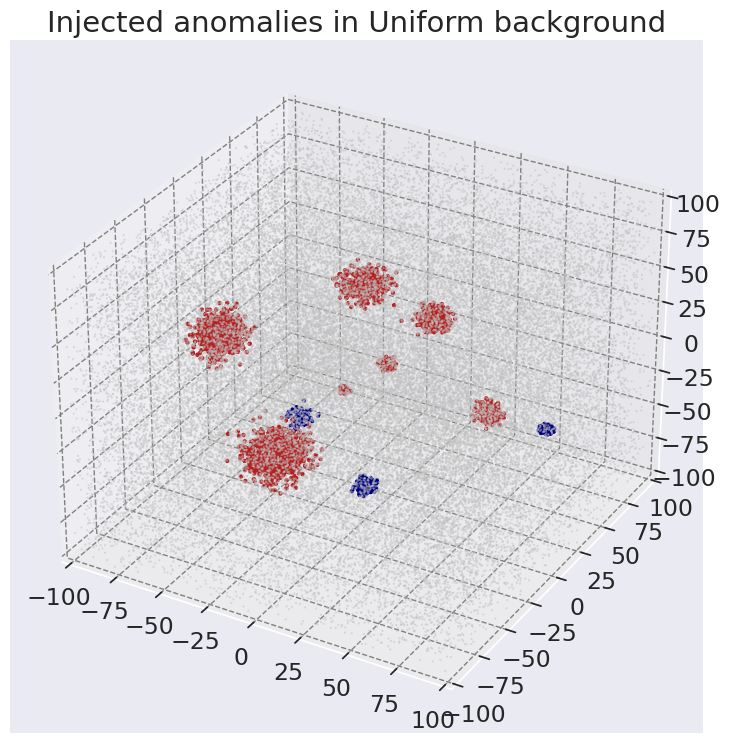

In [3]:
from utils_37 import plot_injected_anomalies_in_uniform_background

# plot of the generated dataset. In silver the background only
# in red the injected overdensities and in blue the injected underdensities
plot_injected_anomalies_in_uniform_background(reference_data, anomaly_sizes_u, test_data, anomaly_sizes_o)

## 2. EagleEye_v7

Reference dataset: $\mathbf{X}$

Test dataset:      $\mathbf{Y}$ 

Define: $\mathbf{U} = \mathbf{X} \cup \mathbf{Y}$

COMPUTE: $\forall i\in U,$  $\Upsilon_i $ whith Inject validation for the data belonging to $\mathbf{X}$ 

Revert the order of Reference and Test to get $\forall j\in U,$  $\Upsilon_{j}(rev) $ whith Inject validation for the data belonging to $\mathbf{Y}$ 

In [4]:
K_M                   = 400
CRITICAL_QUANTILES    = [ 1-1E-4, 1-1E-5 ]
VALIDATION            = reference_data.shape[0]


NUM_CORES             = 10

result_dictionary     = EagleEye_v7.Soar(
    reference_data, test_data, result_dict_in = {}, K_M = K_M, critical_quantiles = CRITICAL_QUANTILES,
    num_cores=NUM_CORES, validation=VALIDATION, partition_size=100 )



Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    /_/ 

Computed p-values for k=263
Computed p-values for k=264
Computed p-values for k=265
Computed p-values for k=266
Computed p-values for k=267
Computed p-values for k=268
Computed p-values for k=269
Computed p-values for k=270
Computed p-values for k=271
Computed p-values for k=272
Computed p-values for k=273
Computed p-values for k=274
Computed p-values for k=275
Computed p-values for k=276
Computed p-values for k=277
Computed p-values for k=278
Computed p-values for k=279
Computed p-values for k=280
Computed p-values for k=281
Computed p-values for k=282
Computed p-values for k=283
Computed p-values for k=284
Computed p-values for k=285
Computed p-values for k=286
Computed p-values for k=287
Computed p-values for k=288
Computed p-values for k=289
Computed p-values for k=290
Computed p-values for k=291
Computed p-values for k=292
Computed p-values for k=293
Computed p-values for k=294
Computed p-values for k=295
Computed p-values for k=296
Computed p-values for k=297
Computed p-values fo

Computed p-values for k=179
Computed p-values for k=180
Computed p-values for k=181
Computed p-values for k=182
Computed p-values for k=183
Computed p-values for k=184
Computed p-values for k=185
Computed p-values for k=186
Computed p-values for k=187
Computed p-values for k=188
Computed p-values for k=189
Computed p-values for k=190
Computed p-values for k=191
Computed p-values for k=192
Computed p-values for k=193
Computed p-values for k=194
Computed p-values for k=195
Computed p-values for k=196
Computed p-values for k=197
Computed p-values for k=198
Computed p-values for k=199
Computed p-values for k=200
Computed p-values for k=201
Computed p-values for k=202
Computed p-values for k=203
Computed p-values for k=204
Computed p-values for k=205
Computed p-values for k=206
Computed p-values for k=207
Computed p-values for k=208
Computed p-values for k=209
Computed p-values for k=210
Computed p-values for k=211
Computed p-values for k=212
Computed p-values for k=213
Computed p-values fo

Max Upsilon remained: 122.38164651592064
Max Upsilon remained: 119.23125324230604
Max Upsilon remained: 118.14090466886742
Max Upsilon remained: 117.59633003859871
Max Upsilon remained: 116.8694943218429
Max Upsilon remained: 114.07982689723136
Max Upsilon remained: 114.03171450059965
Max Upsilon remained: 113.83482459820524
Max Upsilon remained: 113.29816344940971
Max Upsilon remained: 112.07636930491819
Max Upsilon remained: 112.07636930491819
Max Upsilon remained: 110.33761711722346
Max Upsilon remained: 109.27643490068952
Max Upsilon remained: 108.61829822634519
Max Upsilon remained: 108.09042416370832
Max Upsilon remained: 106.57344784766423
Max Upsilon remained: 104.95864123051716
Max Upsilon remained: 104.19344502902672
Max Upsilon remained: 102.11213533997899
Max Upsilon remained: 101.93026806790621
Max Upsilon remained: 101.93026806790621
Max Upsilon remained: 100.38360505711111
Max Upsilon remained: 99.79131195393322
Max Upsilon remained: 99.27874566875391
Max Upsilon remaine

Max Upsilon remained: 25.09333131941423
Max Upsilon remained: 25.079755224464677
Max Upsilon remained: 25.079755224464677
Max Upsilon remained: 24.78849940905299
Max Upsilon remained: 24.77813673979836
Max Upsilon remained: 24.558978252903017
Max Upsilon remained: 24.498462020543677
Max Upsilon remained: 24.44129021835178
Max Upsilon remained: 24.266393777960737
Max Upsilon remained: 24.15256494608156
Max Upsilon remained: 24.095658142875294
Max Upsilon remained: 23.871626173081573
Max Upsilon remained: 23.811910449212714
Max Upsilon remained: 23.809309346169144
Max Upsilon remained: 23.69772848316627
Max Upsilon remained: 23.413835536061068
Max Upsilon remained: 23.240335155946376
Max Upsilon remained: 23.02317965689126
Max Upsilon remained: 22.83227042914459
Max Upsilon remained: 22.464048038251168
Max Upsilon remained: 22.083061665661976
Max Upsilon remained: 21.8399705589548
Max Upsilon remained: 21.70678287027952
Max Upsilon remained: 21.611764390220184
Max Upsilon remained: 21.43

#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y} $ 

#### Underdensities reference_set:
result_dictionary['stats']['Upsilon_i_Val_plus'] : $\Upsilon_i, i\in \mathbf{X} $ (the IV one)

#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 

#### Underdensities test_set:
result_dictionary['stats_reverse']['Upsilon_i_Val_plus'] : $\Upsilon_j(rev), j\in \mathbf{Y} $ (the IV one)

### 2.1 Visualize the putative anomalous points

Plot values marked as putative anomalies. 

The overdensities within the test dataset are colored based on their $\Upsilon_i $ with red cmap.

The overdensities within the reference dataset are colored based on their $\Upsilon_i(rev) $ with blue cmap.


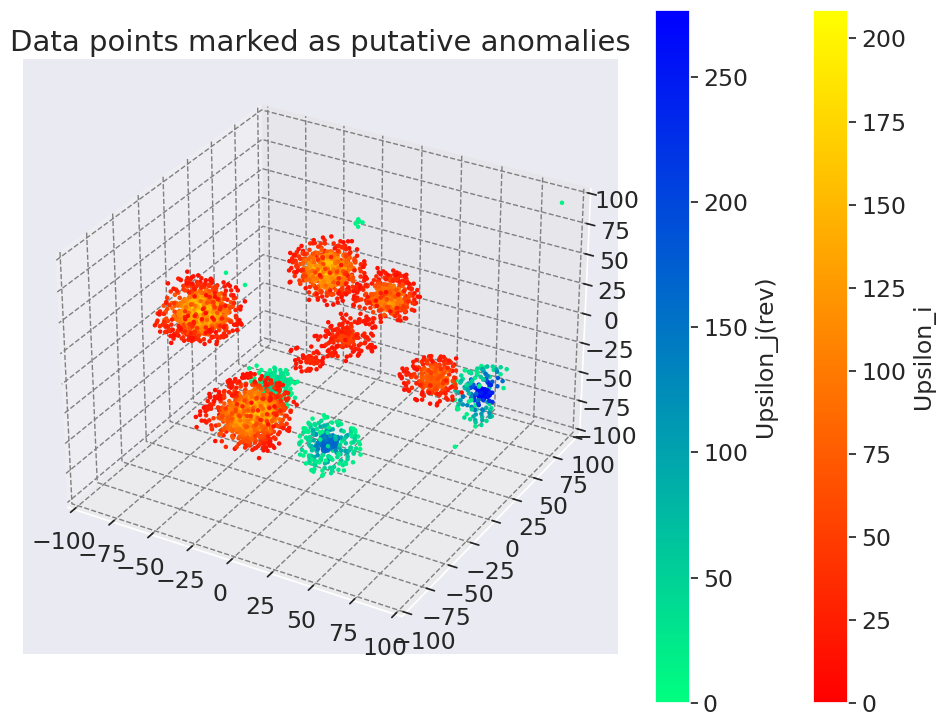

In [5]:
from utils_37 import     plot_data_points_marked_as_putative_anomalies


plot_data_points_marked_as_putative_anomalies(test_data, reference_data, result_dictionary )

## 3 Iterative Equalization

Pipeline for
#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y}$; 

1) While $\exists i \in \mathbf{Y}$ such that $\Upsilon_i \geq \Upsilon_*$;

2) Identify the index $i_{max}$ such that maximize $\Upsilon_{i_{max}} = \max_{i\in \mathbf{Y}}{\Upsilon_i}$;

3) Remove $i_{\text{max}}$ and its nearest neighbours up to the next $\mathbf{X}$ data point from the set $\mathbf{Y}$. Store all removed points in a new set $\mathbf{W_o}$. Update the set $\mathbf{U} = \mathbf{U} \setminus \mathbf{W_o}$;

4)  Recompute $\Upsilon_i, i\in \mathbf{Y}$ for the remaining points in $\mathbf{Y}$ that still exceed $\Upsilon_*$, restricting the nearest-neighbour search to updated $\mathbf{U}$ that do not include points in $\mathbf{W_o}$.

5) Return to point 1)

Pipeline for
#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 

1) While $\exists j \in \mathbf{X}$ such that $\Upsilon_j(rev) \geq \Upsilon_*$;

2) Identify the index $j_{max}$ such that maximize $\Upsilon_{j_{max}}(rev) = \max_{j\in \mathbf{X}}{\Upsilon_j}(rev)$;

3) Remove $j_{\text{max}}$ and its nearest neighbours up to the next $\mathbf{Y}$ data point from the set $\mathbf{X}$. Store all removed points in a new set $\mathbf{W_u}$. Update the set $\mathbf{U} = \mathbf{U} \setminus \mathbf{W_u}$; 

4)  Recompute $\Upsilon_j(rev), j\in \mathbf{X}$ for the remaining points in $\mathbf{X}$ that still exceed $\Upsilon_*$, restricting the nearest-neighbour search to updated $\mathbf{U}$ that do not include points in $\mathbf{W_u}$.

5) Return to point 1)




### 3.1 Visualize $\mathbf{W_o}$ and $\mathbf{W_u}$

Plot values marked extracted by iterative equalization. 

The overdensities within the test dataset $\mathbf{W_o}$ are colored in red.

The overdensities within the reference dataset $\mathbf{W_u}$ are colored blue.


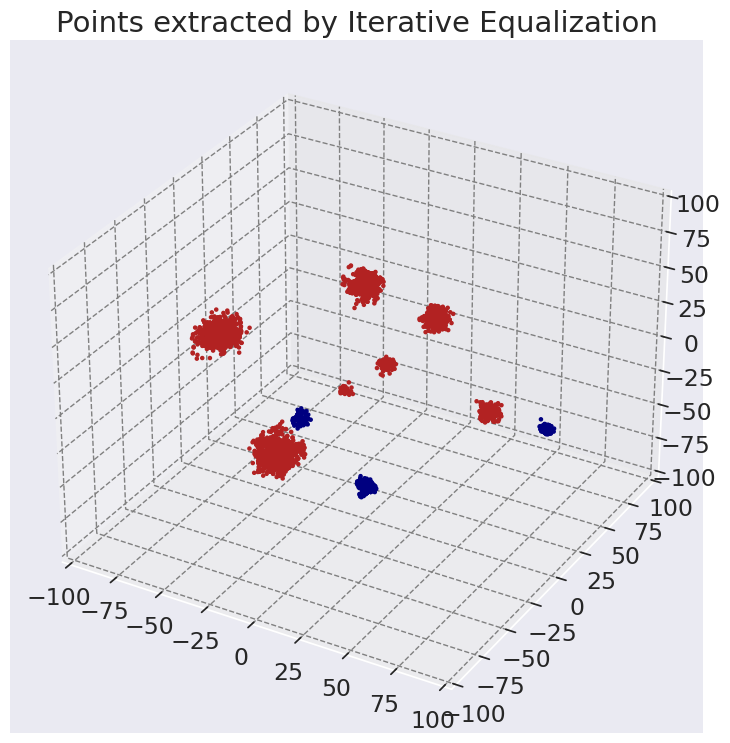

In [6]:
from utils_37 import     plot_points_extracted_by_iterative_equalization
qt = 1 # which of the given quantiles to consider
plot_points_extracted_by_iterative_equalization( test_data, reference_data, result_dictionary, threshold=CRITICAL_QUANTILES[qt] )


## 4 Clustering and aggregating

In order to get statistics from our computaitons let us partition the datapoints such that $\Upsilon_i, i\in \mathbf{Y}$ and $\Upsilon_j(res), j\in \mathbf{X}$ that were inititaly greater then $\Upsilon_*$:

#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y} $ 

#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 



### 4.1 Intersect the thus obtained clusters with $\mathbf{W_o}$ and $\mathbf{W_u}$

#### 4.1.1 Overdensities test:

##### 1) Within each overdensity cluster identify the $i_{loc}$ such that $\Upsilon_{i_{loc}} = \min_{i \in \mathbf{W_o}}\Upsilon_{i} $

##### 2) Within each overdensity cluster keep all points such that $\Upsilon_{i} >= \Upsilon_{i_{loc}}, i\in \mathbf{U}$.


##### 3) Get the desired statistics by separatelly considering those comming fom \mathbf{X} (background whithin that cluster) and those comming from \mathbf{Y}.


#### 4.1.2 :Overdensities reference (underdensities):

##### 1) Within each overdensity cluster identify the $j_{loc}$ such that $\Upsilon_{j_{loc}}(rev) = \min_{j \in \mathbf{W_u}}\Upsilon_{j}(rev) $

##### 2) Within each overdensity cluster keep all points such that $\Upsilon_{j}(rev) >= \Upsilon_{j_{loc}}(rev), j\in \mathbf{U}$.


##### 3) Get the desired statistics by separatelly considering those comming fom \mathbf{Y} (test underdensities belonging to that cluster) and those comming from \mathbf{X}.


In [7]:
#%% # Clustering

clusters = EagleEye_v7.partitian_function(reference_data,test_data,result_dictionary,result_dictionary['Upsilon_star_plus'][qt], result_dictionary['Upsilon_star_minus'][qt],K_M=K_M)

#clusters_plus,clusters_minus = clusters

#%% # Creation of the dictionaries
IV_IE_dict = EagleEye_v7.IV_IE_get_dict(clusters,result_dictionary,[CRITICAL_QUANTILES[qt]],test_data,reference_data)



Computation of distances started
Computation of the distances up to 400 NNs started
0.31 seconds for computing distances
ID estimation finished: selecting ID of [2.96]
kstar estimation started, Dthr = 23.92812698
0.04 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.002 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.006 sec
('Number of clusters before multimodality test=', 7)
Identification of the saddle points:  0.011 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0004038810729980469 sec
Clustering finished, 7 clusters found
total time is, 0.021454811096191406
Computation of distances started
Computation of the distances up to 400 NNs started
0.08 seconds for computing distances
ID estimation finished: selecting ID of [3.13]
kstar estimation start

#### Structure of the dictionary containing the results
    IV_IE_dict = {
    "OVER_clusters": {
        i: {"IE_extra": None, "From_test": None, "From_ref": None}
        for i in range(len(clusters_plus))
    },
    "UNDER_clusters": {
        i: {"IE_extra": None, "From_test": None, "From_ref": None}
        for i in range(len(clusters_minus))
    }
    }

### 4.2 Visualize Clustered Overdensities and Underdensities 

#### 4.2.1 Clustering of points removed by itarative equalization

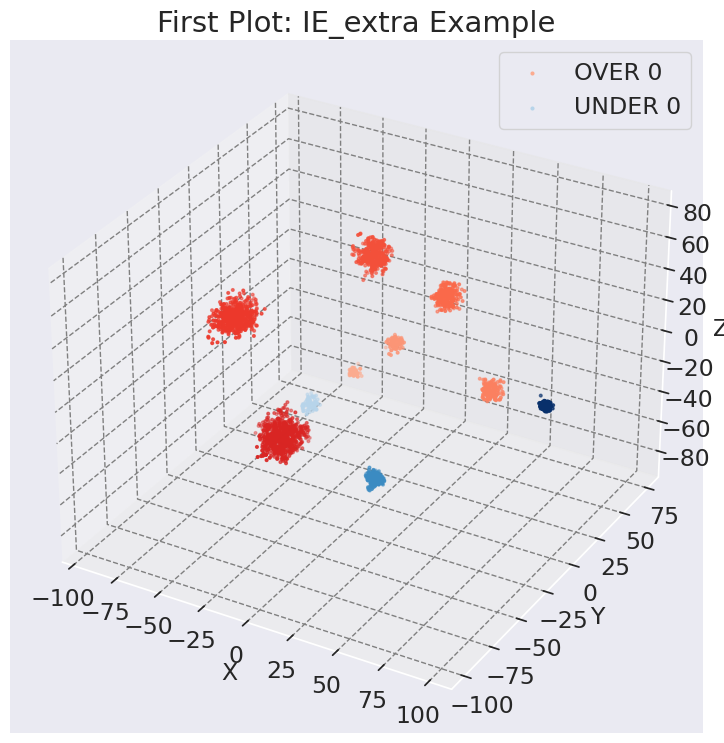

In [8]:
from utils_37 import plot_3d_ie_extra

plot_3d_ie_extra(IV_IE_dict, test_data, reference_data)


#### 4.2.2 Clustering of aggregaed Overdensities wrt test data ( shades of reds ) and reference data (shades of blus)

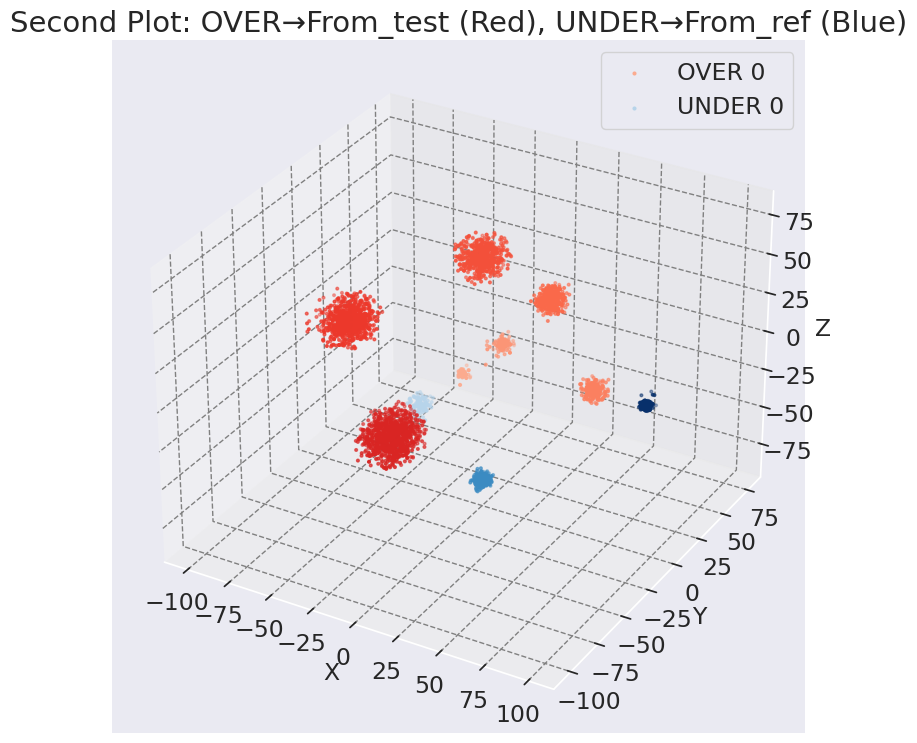

In [9]:
from utils_37 import plot_3d_second

# Clustering of anomalous points:
plot_3d_second(IV_IE_dict, test_data, reference_data)


#### 4.2.3 Clustering of aggregated Underdensities in the test dataset (red) and refereference dataset (blus)

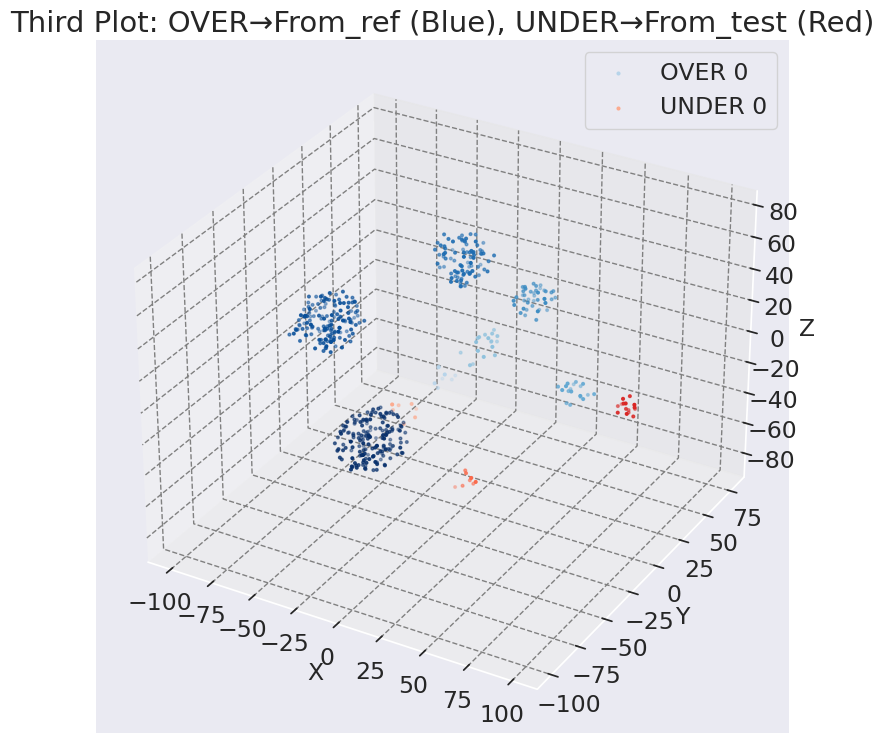

In [10]:
from utils_37 import plot_3d_third


# Background from the opposite dataset wrt the clustered anomalies:
plot_3d_third(IV_IE_dict, test_data, reference_data)


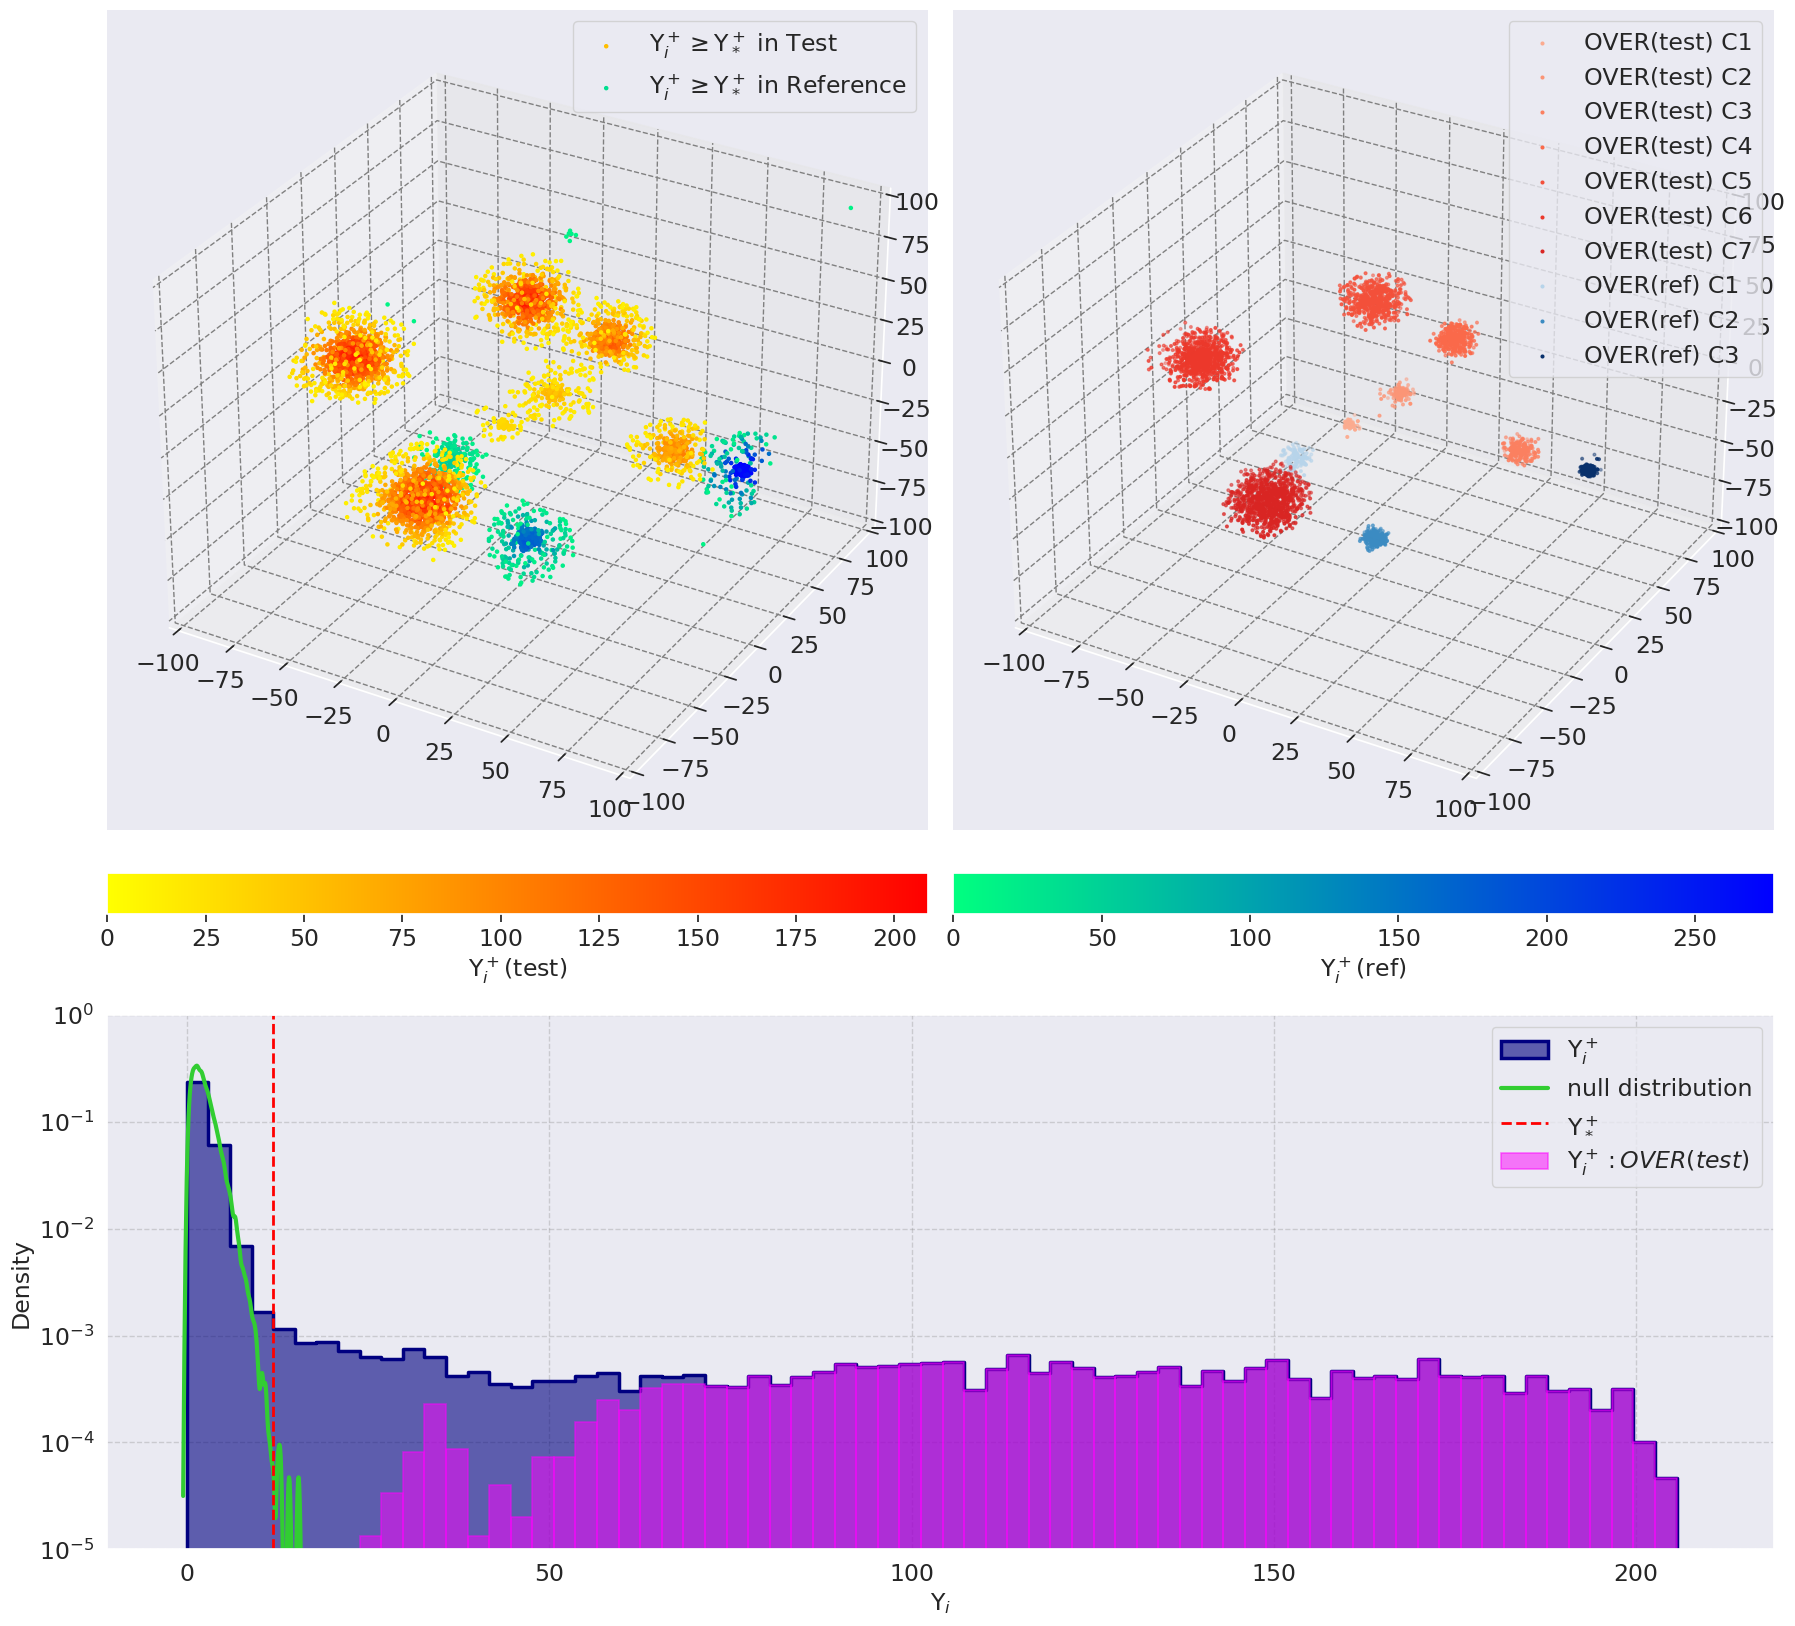

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Suppose these are your arrays of Upsilon_i^+ for all test points and for the "OVER" subset
data_all = result_dictionary['stats']['Upsilon_i_plus']
all_overdensities = [
    idx 
    for cluster_data in over_clusters.values() 
    for idx in cluster_data.get('From_test', [])
]
data_sub = data_all[all_overdensities]

fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

# 3D subplots (ax0, ax1) ...
ax0 = fig.add_subplot(gs[0, 0], projection='3d')
ax1 = fig.add_subplot(gs[0, 1], projection='3d')
# 1D distribution subplot
ax2 = fig.add_subplot(gs[1, :])

# -------------------------------------------------------------------------
# Then continue with your plotting code exactly as before:
axes = [ax0, ax1, ax2]

#############################################################################
# Everything below remains exactly as you had it (titles, colorbars, etc.)   #
#############################################################################

idx_plot = result_dictionary['stats']['Upsilon_i_plus'] >= result_dictionary['Upsilon_star_plus'][0]
sc1 = axes[0].scatter(
    test_data[idx_plot, 0],
    test_data[idx_plot, 1],
    test_data[idx_plot, 2],
    c=result_dictionary['stats']['Upsilon_i_plus'][idx_plot],
    cmap='autumn_r',
    label='$\\Upsilon_i^+ \geq \\Upsilon_*^+$ in Test',
    alpha=1,
    s=5,
    vmin=0
)

# Colorbar for the first scatter
colorbar1 = fig.colorbar(sc1, ax=axes[0], orientation='horizontal', fraction=0.045, pad=0.04)
colorbar1.set_label('$\\Upsilon_i^+$(test)')

idx_plot2 = result_dictionary['stats_reverse']['Upsilon_i_plus'] >= result_dictionary['Upsilon_star_minus'][0]
sc2 = axes[0].scatter(
    reference_data[idx_plot2, 0],
    reference_data[idx_plot2, 1],
    reference_data[idx_plot2, 2],
    c=result_dictionary['stats_reverse']['Upsilon_i_plus'][idx_plot2],
    label='$\\Upsilon_i^+ \geq \\Upsilon_*^+$ in Reference',
    cmap='winter_r',
    alpha=1,
    s=5,
    vmin=0
)
colorbar2 = fig.colorbar(sc2, ax=axes[1], orientation='horizontal', fraction=0.045, pad=0.04)
colorbar2.set_label('$\\Upsilon_i^+$(ref)')

axes[0].set_xlim(-100, 100)
axes[0].set_ylim(-100, 100)
axes[0].set_zlim(-100, 100)
#axes[0].set_title("$\\Upsilon_i^+ \geq \\Upsilon_*^+$ in Test and Reference ", fontsize=14)
axes[0].legend()
over_clusters = IV_IE_dict.get("OVER_clusters", {})
under_clusters = IV_IE_dict.get("UNDER_clusters", {})

n_over = len(over_clusters)
n_under = len(under_clusters)

over_Reds = get_shades(n_over, 'Reds')
under_Blues = get_shades(n_under, 'Blues')

for idx, (cluster_id, cluster_data) in enumerate(over_clusters.items()):
    row_indices = cluster_data.get("From_test", [])
    if not row_indices:
        continue
    cluster_points = test_data[row_indices]
    xs, ys, zs = cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2]
    axes[1].scatter(xs, ys, zs, c=[over_Reds[idx]], marker='.', s=15,
                    label=f"OVER {cluster_id}" if idx == 0 else "")

for idx, (cluster_id, cluster_data) in enumerate(under_clusters.items()):
    row_indices = cluster_data.get("From_ref", [])
    if not row_indices:
        continue
    cluster_points = reference_data[row_indices]
    xs, ys, zs = cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2]
    axes[1].scatter(xs, ys, zs, c=[under_Blues[idx]], marker='.', s=15)

#axes[1].set_title("Clustered Anomalies:\n OVER(test) (shades of Red), \n OVER(ref) (shades of Blue)", fontsize=14)
axes[1].set_xlim(-100, 100)
axes[1].set_ylim(-100, 100)
axes[1].set_zlim(-100, 100)
axes[1].legend(['OVER(test) C1','OVER(test) C2','OVER(test) C3','OVER(test) C4','OVER(test) C5','OVER(test) C6','OVER(test) C7','OVER(ref) C1','OVER(ref) C2','OVER(ref) C3'])

# -------------------------------------------------------------------------

# Now let's do the histogram on ax2.
ax2.set_yscale('log')

# --- 1) Plot the navy histogram with Seaborn (all data) ---
sns.histplot(
    data_all,
    bins=70,
    kde=False,
    stat='density',  # important to match the manual density calculation
    label=r'$\Upsilon_i^+$ ',
    color='navy',
    element='step',
    linewidth=2.5,
    alpha=0.6,
    ax=ax2
)

# --- 2) Plot the KDE for the null distribution (optional) ---
sns.kdeplot(
    result_dictionary['Upsilon_i_plus_null'],
    color='limegreen',
    label='null distribution',
    linewidth=3,
    ax=ax2
)

# --- 3) Manually compute the fraction-based histogram for the subset ---
# Use the same bins as above for a proper overlay:
num_bins = 70
counts_all, bin_edges = np.histogram(data_all, bins=num_bins)
counts_sub, _         = np.histogram(data_sub, bins=bin_edges)

# compute bin centers and widths for the bar plot
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widths  = bin_edges[1:] - bin_edges[:-1]

N_all = len(data_all)
density_all = counts_all / (N_all * bin_widths)

ratio = np.zeros_like(counts_all, dtype=float)
valid = counts_all > 0
ratio[valid] = counts_sub[valid] / counts_all[valid]

# final "fraction-of-navy" density for each bin
density_sub = density_all * ratio  # = counts_sub / (N_all * bin_widths)

# plot these densities as bars
ax2.bar(
    bin_centers,
    density_sub,
    width=bin_widths,
    color='magenta',
    alpha=0.5,
    edgecolor='magenta',
    linewidth=1.2,
    label='$\\Upsilon_i^+ :OVER(test)$'
)

# optional vertical line
ax2.axvline(
    x=result_dictionary['Upsilon_star_plus'][0],
    color='red',
    linestyle='--',
    linewidth=2,
    label=r'$\Upsilon_*^+$'
)

ax2.set_xlabel(r'$\Upsilon_i$')
ax2.set_ylim([1e-5, 1e0])  # depends on your data
ax2.legend()

plt.tight_layout()
plt.show()
